In [1]:
import findspark
findspark.init('C:\\spark\\spark-2.3.1-bin-hadoop2.7')

In [2]:
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import numpy as np
from pyspark.sql import SparkSession, functions, types
from pyspark.sql.functions import stddev, avg, broadcast, max
from datetime import datetime
from pyspark.sql.functions import col, split
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml import PipelineModel, Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer, MinMaxScaler, OneHotEncoder, HashingTF, IDF
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.appName('useful_model').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.3' # make sure we have Spark 2.3+

from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Collecting data
data = spark.read.parquet('MLearn/train')
data = data.cache()
data.columns

['average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'fans',
 'review_count',
 'useful',
 'review_useful_votes',
 'friends_count',
 'reviewtext_count',
 'no_months',
 'useful_category']

<b>predictors and target:</b><br>
'average_stars' - average stars the user has received<br>
'compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list','compliment_more','compliment_note',<br>
'compliment_photos','compliment_plain','compliment_profile','compliment_writer' - compiments received by the user<br>
'fans' - number of fans the user has<br>
'review_count' - number of reviews given by the user<br>
'useful' - count of user's useful votes<br>
'review_useful_votes' - useful votes for a review<br>
'friends_count' - number of friends the user has<br>
'reviewtext_count' - length of the review text<br>
'no_months' - yelping period in months<br>
'useful_category' - usefulness category to be predicted<br>

In [4]:
#checking data for each class
class_count = data.groupby("useful_category").count().orderBy('count', ascending=False).cache()
class_count.show()

+----------------+-------+
| useful_category|  count|
+----------------+-------+
|      not_useful|4312385|
| slightly_useful| 340849|
|moderatly_useful|  68148|
|   highly_useful|  46254|
|extremely_useful|  30096|
+----------------+-------+



In [5]:
# Finding min count
min_count = class_count.agg({"count": "min"}).collect()[0][0]
category_list = class_count.select("useful_category").rdd.flatMap(lambda x: x).collect()
category_count_list = class_count.select("count").rdd.flatMap(lambda x: x).collect()

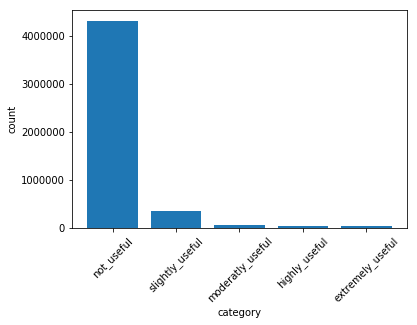

In [6]:
# Plot class count
plt.bar(category_list,category_count_list)
plt.xticks(rotation=45)
plt.xlabel('category')
plt.ylabel('count')
plt.show()

In [8]:
train_bal = data.filter(data["useful_category"] == functions.lit("not_useful")).limit(min_count)

# balancing count
for category in category_list:
    if category!="not_useful":
        train_bal = train_bal.union(data.filter(data["useful_category"] == category).limit(min_count))
class_count_bal = train_bal.groupby("useful_category").count().cache()
balanced_category_list = class_count_bal.select("useful_category").rdd.flatMap(lambda x: x).collect()
balanced_category_count_list = class_count_bal.select("count").rdd.flatMap(lambda x: x).collect()

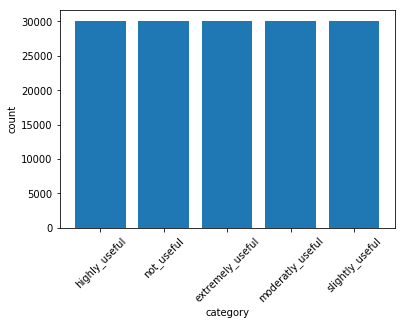

In [9]:
# Balanced count plot
plt.bar(balanced_category_list,balanced_category_count_list)
plt.xticks(rotation=45)
plt.xlabel('category')
plt.ylabel('count')
plt.show()

In [10]:
#total count of train data
class_count_bal.unpersist()
class_count.unpersist()
train_data_model,validation = train_bal.randomSplit([0.8, 0.2],seed=1234) 
train_data_model = train_data_model.cache()
validation = validation.cache()
train_data_model.count()

120355

Model Logistic Regression:

In [11]:
req_columns = ['average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'fans',
 'review_count',
 'useful',
 'friends_count',
 'reviewtext_count',
 'no_months']

vec_assembler = VectorAssembler(inputCols=req_columns, outputCol="features")
label_string = StringIndexer(inputCol = "useful_category", outputCol = "label")
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
logit_reg = LogisticRegression(featuresCol="scaledFeatures", labelCol="label",family="multinomial",maxIter=100, regParam=0.3, elasticNetParam=0.0)

In [13]:
useful_pipeline = Pipeline(stages=[vec_assembler,label_string, min_max_scaler,logit_reg])

useful_model = useful_pipeline.fit(train_data_model)
useful_predictions = useful_model.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label")
score = evaluator.evaluate(useful_predictions)
print('Validation score for model using LogisticRegression: %g' % (score))

Validation score for model using LogisticRegression: 0.3178


In [14]:
# Taking another validation sample
validation = data.sample(False, 0.006, seed=0).cache()
validation.count()

28681

In [15]:
# Running test again 
useful_model = useful_pipeline.fit(train_data_model)
useful_predictions = useful_model.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label")
score = evaluator.evaluate(useful_predictions)
print('Validation score for model using LogisticRegression: %g' % (score))

Validation score for model using LogisticRegression: 0.798007


In [16]:
#Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(logit_reg.regParam, [0.1, 0.01, 0.05]) # regularization parameter
             .addGrid(logit_reg.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter
             .addGrid(logit_reg.maxIter, [10, 50, 100]) #Number of iterations
             .build())

#Create 5 fold CrossValidator
cross_valid = CrossValidator(estimator=useful_pipeline, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=MulticlassClassificationEvaluator(), \
                    numFolds=5)
cvModel = cross_valid.fit(train_data_model)

In [17]:
best_model = cvModel.bestModel

# Model Stages
best_model.stages

[VectorAssembler_44d4ad00cffbd65855c0,
 StringIndexer_40d6a219e9527b1f26ed,
 MinMaxScaler_4a3798471909277d0b52,
 LogisticRegression_4ebbaceb0e168f7f3b86]

In [18]:
#Best Parameters
import numpy as np
cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]

{Param(parent='LogisticRegression_4ebbaceb0e168f7f3b86', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='LogisticRegression_4ebbaceb0e168f7f3b86', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_4ebbaceb0e168f7f3b86', name='maxIter', doc='max number of iterations (>= 0).'): 50}

In [19]:
predictions_lr_best = cvModel.transform(validation)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
best_score_lr = evaluator.evaluate(predictions_lr_best)

print('Validation score for model using LogisticRegression-Best: %g' % (best_score_lr))

Validation score for model using LogisticRegression-Best: 0.790304


Other Models:

In [20]:
# Using Decision Tree Classifier
vec_assembler = VectorAssembler(inputCols=req_columns, outputCol="features")
label_string = StringIndexer(inputCol = "useful_category", outputCol = "label")
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
dtc = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="label")
useful_pipeline_dtc = Pipeline(stages=[vec_assembler,label_string, min_max_scaler,dtc])
useful_model_dtc = useful_pipeline_dtc.fit(train_data_model)
useful_predictions_dtc = useful_model_dtc.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label")
score_dtc = evaluator.evaluate(useful_predictions_dtc)
print('Validation score for model using Decision Tree Classifier: %g' % (score_dtc))

Validation score for model using Decision Tree Classifier: 0.717459


In [21]:
# Using Random Forest Classifier
vec_assembler = VectorAssembler(inputCols=req_columns, outputCol="features")
label_string = StringIndexer(inputCol = "useful_category", outputCol = "label")
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
rf = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures", numTrees=10)
useful_pipeline_rf = Pipeline(stages=[vec_assembler,label_string, min_max_scaler,rf])
useful_model_rf = useful_pipeline_rf.fit(train_data_model)
useful_predictions_rf = useful_model_rf.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label")
score_rf = evaluator.evaluate(useful_predictions_rf)
print('Validation score for model using Random Forest Classifier: %g' % (score_rf))

Validation score for model using Random Forest Classifier: 0.778964


In [22]:
# Using Naive Bayes Classifier
vec_assembler = VectorAssembler(inputCols=req_columns, outputCol="features")
label_string = StringIndexer(inputCol = "useful_category", outputCol = "label")
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
NB = NaiveBayes(smoothing=1.0, modelType="multinomial",featuresCol="scaledFeatures", labelCol="label")
useful_pipeline_NB = Pipeline(stages=[vec_assembler,label_string, min_max_scaler,NB])
useful_model_NB = useful_pipeline_NB.fit(train_data_model)
useful_predictions_NB = useful_model_NB.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label")
score_NB = evaluator.evaluate(useful_predictions_NB)
print('Validation score for model using Naive Bayes Classifier: %g' % (score_NB))

Validation score for model using Naive Bayes Classifier: 0.805217


In [23]:
#Using Multilayer perceptron classifier
vec_assembler = VectorAssembler(inputCols=req_columns, outputCol="features")
label_string = StringIndexer(inputCol = "useful_category", outputCol = "label")
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
mlp = MultilayerPerceptronClassifier(featuresCol="scaledFeatures", labelCol="label",maxIter=1000, layers=[18, 36, 36], blockSize=32, seed=123)
useful_pipeline_mlp = Pipeline(stages=[vec_assembler,label_string, min_max_scaler,mlp])
useful_model_mlp = useful_pipeline_mlp.fit(train_data_model)
useful_predictions_mlp = useful_model_mlp.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label")
score_mlp = evaluator.evaluate(useful_predictions_mlp)
print('Validation score for model using Multilayer perceptron classifier: %g' % (score_mlp))

Validation score for model using Multilayer perceptron classifier: 0.778152


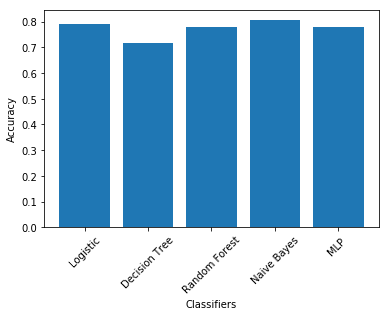

[0.790303821549092, 0.7174585460784071, 0.7789640940755916, 0.80521672491948, 0.7781522148198526]


In [24]:
# Plotting Accuracies
plt.bar(["Logistic","Decision Tree","Random Forest","Naive Bayes","MLP "],\
        [best_score_lr,score_dtc,score_rf,score_NB,score_mlp])
plt.xticks(rotation=45)
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()
scores_list = [best_score_lr,score_dtc,score_rf,score_NB,score_mlp]
print(scores_list)

In [25]:
# NB Classifier is the best
# Saving model with best accuracy
useful_model_NB.write().overwrite().save("BestModelUseful")

In [26]:
# Loading model
load_model = PipelineModel.load("BestModelUseful")
test_data = spark.read.parquet("MLearn/test")
test_data = test_data.cache()
predictions_test = load_model.transform(test_data)
predictions_test = predictions_test.orderBy("label").cache()
evaluator_test = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label")
score_test = evaluator_test.evaluate(predictions_test)
print('Test score for model: %g' % (score_test))

Test score for model: 0.800962


In [27]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

y_true = predictions_test.select("label")
y_true = y_true.toPandas()

y_pred = predictions_test.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[  1282,   1977,   3726,    921,   3586],
       [   759,   2428,   1955,    528,   1975],
       [  4660,   3490,  29695,   5124,  42179],
       [  1558,   1852,   5960,   1513,   6298],
       [ 11997,   3419, 175145,  12486, 874751]], dtype=int64)

In [28]:
# prediction labels
predictions_test.groupby("useful_category","label").count().show()

+----------------+-----+-------+
| useful_category|label|  count|
+----------------+-----+-------+
|   highly_useful|  0.0|  11492|
|extremely_useful|  1.0|   7645|
| slightly_useful|  2.0|  85148|
|moderatly_useful|  3.0|  17181|
|      not_useful|  4.0|1077798|
+----------------+-----+-------+



Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

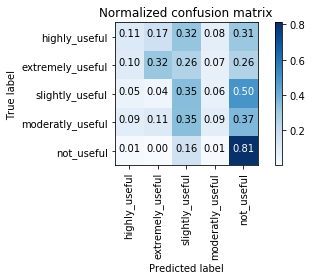

<Figure size 432x288 with 0 Axes>

In [29]:
from sklearn.metrics import confusion_matrix
import itertools
'''
plot_confusion_matrix taken from
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#sphx-glr-download-auto-examples-model-selection-plot-confusion-matrix-py
'''
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
class_list = ["highly_useful","extremely_useful","slightly_useful","moderatly_useful","not_useful"]
plot_confusion_matrix(cnf_matrix, classes=class_list, normalize=True, title='Normalized confusion matrix')
plt.figure()

In [30]:
print('Test score for model: %g' % (score_test))

Test score for model: 0.800962


<b>Categories</b> - <br>
"not_useful" - less than 4 useful votes<br>
"slightly_useful" - between 4 and 7 useful votes<br>
"moderatly_useful" - between 8 and 10 useful votes<br>
"highly_useful" - between 11 and 16 useful votes<br>
"extremely_useful" - more than 16 useful votes<br>
<br>
Test score for model: 0.800962
<br>
Achieved <b>80%</b> accuracy on the model